# OzStar Results MOA Analysis Code MultiAge
## 02/10/24
## Spencer Collaviti

In [1]:
# Import requisite libraries
import Config as conf # Pick up the local config file
import sys
sys.path.append("../../SimulationCode")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import BaryakhtarFunctions as func
import copy
import superrad as sr
import superrad.harmonics as har
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

In [2]:
def interpolate(list1, list2, x):
    check = True
    i = 0
    if x < min(list1):
        return np.nan
    elif x > max(list1):
        return np.nan
    while check:
        if x <= list1[i]:
            check = False
            i -= 1
            return (list2[i] + ((list2[i+1]-list2[i])/(list1[i+1]-list1[i]))*(x-list1[i]))
        i += 1
        if i >= len(list1):
            check = False
            return np.nan
        
def lin_fit(x1,y1,x2,y2,x):
    return y1 + ((y2-y1)/(x2-x1))*(x-x1)
        
def find_match_index(x,x_list):
    if x < min(x_list):
        return 0
    elif x > max(x_list):
        return -1
    else:
        i = 0
        for j in range(len(x_list)):
            if x_list[j] <= x:
                i = j
        return i
    
def tick_function(X):
    return ["%.2f" % z for z in X]

## Generate the plot

0.3535533905932738
0.6274304974166566
0.7070314888857564


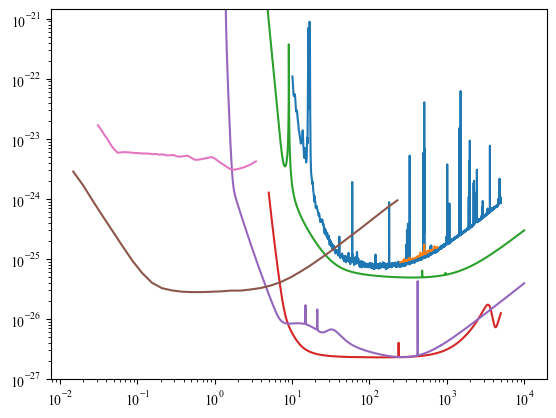

In [3]:
# Determine the sensitivity to gravitational waves
# Define inclination
iota = 90*(2*np.pi/360) # Inclination angle
# Define Constants
h = 6.6260715e-34
c = 299792458
e = 1.60217663e-19

# Define correction factor from angular-averaged value
ang_corr_factor = 0.3561962678776969
# Compute angular distribution correction factor

# For 211
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc
h_factor_211 = ((ang_211_power(1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# For 322
Mc = 1.0
Mbh = 14.8
abh = 0.5
_m = 2
mu_fac = 7.48548859e9
_mu = 1e-13*mu_fac # eV by factor
d_fac = 4.78691895e-20
_d = 2.25e-3*d_fac
_cloud_model = sr.rel_sca_cloud.RelScalar()

thetaObs_array = np.linspace(0,1*np.pi,num=101)
hp_array = np.zeros_like(thetaObs_array)
hx_array = np.zeros_like(thetaObs_array)

for i, thetaObs in enumerate(thetaObs_array):
    strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
    hl = strain_vec(_m, _mu*Mbh, abh)

    hp = 0.0
    hx = 0.0
    l = 2*_m 
    for hl0 in hl:
        Yp = har.sYlm(-2,l,2*_m,thetaObs)
        Ym = har.sYlm(-2,l,-2*_m,thetaObs)
        hp = hp + hl0*(Yp+(-1)**l*Ym)
        hx = hx + hl0*(Yp-(-1)**l*Ym)
        l = l + 1
    delta = np.angle(hx)-np.angle(hp)
    #Make delta in [-pi,pi)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
    hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)

    hp_array[i] = hp
    hx_array[i] = hx

auc = np.trapz(np.sin(thetaObs_array)*(hp_array**2+hx_array**2))

strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
hl = strain_vec(_m, _mu*Mbh, abh)

hp = 0.0
hx = 0.0
l = 2*_m 
for hl0 in hl:
    Yp = har.sYlm(-2,l,2*_m,iota)
    Ym = har.sYlm(-2,l,-2*_m,iota)
    hp = hp + hl0*(Yp+(-1)**l*Ym)
    hx = hx + hl0*(Yp-(-1)**l*Ym)
    l = l + 1
hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)

h_factor_322 = (((hp**2+hx**2)/auc)/max_v_auc_211)**0.5

# For transition
def ang_transition_power(N_211,N_322,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = func.G*func.hbar**2/(np.pi*func.c)
    scale = N_322*N_211*alpha**14/r_g**4
    angular_dependence = 2**5/(3**6*5**8)*(1-np.cos(theta)**4)+((27+28*np.cos(2*theta)+9*np.cos(4*theta))*np.sin(theta)**2)/\
    (2**2*3**6*5**10*7**2)
    return const*scale*angular_dependence

# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
ang_transition_template = ang_transition_power(1e76,1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_transition_template)
# Compute h factor function
h_factor_tr = ((ang_transition_power(1e76,1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# Report results (rel. to h for face-on 211 annihilation signal)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

# Read in sensitivity curves
sens_dict = func.read_in_sensitivity_curves("../SensitivityCurves/")
# Add extra curve for Lilli's PSD
sens_dict["o2_real"] = func.read_in_lilli_sensitivity_curves("../o2-psd-H1L1.txt")

# Read in detection bounds for O2 Search on Cygnus
ref_frequencies = [201.2]
ref_h0_bounds = [4.7e-26]
ref_ASDs = [4e-24]

# Define curves to find prospective sensitivity
curves_of_interest = ["o2","o2_real","aligo_design","ce2","et_d","decigo","magiss-r"]
# Define dictionary to store bounds
h0_211_bounds_dict = dict()
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = []
    for val in ref_frequencies:
        h0_211_bounds_dict[curve].append(np.zeros_like(sens_dict[curve][0]))
        
# Find prospective sensitivity for each curve
for curve in curves_of_interest:
    freq_list = sens_dict[curve][0]
    ASD_list = sens_dict[curve][1]
    for i in range(len(ref_frequencies)):
        ref_freq = ref_frequencies[i]
        ref_h0_bound = ref_h0_bounds[i]
        ref_ASD = ref_ASDs[i]
        for k in range(len(freq_list)):
            freq = freq_list[k]
            ASD = ASD_list[k]
            if curve == "o2_real":
                T_obs_scale = (233/80)
            else:
                T_obs_scale = (365/80) # (233/80)**2
            T_coh_scale = 10/8
            h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(ASD/ref_ASD)*\
            (T_coh_scale*T_obs_scale)**(-1/4)*2**0.5#*(freq/ref_freq)**(1/4)

# Making a call: taking the mean of all points
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = h0_211_bounds_dict[curve][0]*ang_corr_factor
    
h0_211_bounds_dict_MOA = {}
for key in h0_211_bounds_dict:
    h0_211_bounds_dict_MOA[key] = h0_211_bounds_dict[key]/h_factor_211
h0_322_bounds_dict_MOA = {}
for key in h0_211_bounds_dict:
    h0_322_bounds_dict_MOA[key] = h0_211_bounds_dict[key]/h_factor_322
h0_tr_bounds_dict_MOA = {} 
for key in h0_211_bounds_dict:
    h0_tr_bounds_dict_MOA[key] = h0_211_bounds_dict[key]/h_factor_tr
    
# Check that plot generated successfully
for curve in curves_of_interest:
    plt.plot(sens_dict[curve][0],h0_211_bounds_dict_MOA[curve])
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e-27,None)

In [4]:
# Define common parameters
bhmi = 7.3
bhmf_goal = 7.3
bhsi = 0.99
d = 1.58*3.086e19 # Distance to MOA-2011 in metres
iota = 90*(2*np.pi/360) # Inclination angle
save = True # Whether to save plots
save_folder = "../OutputPlots/" # Where to save plots

# Define Constants
h = 6.6260715e-34
c = 299792458
e = 1.60217663e-19

# Path by age
age_dir = {1e4:"MOAResults/results1e4/",1e6:"MOAResults/results1e6/",1e8:"MOAResults/results1e8/"}

# Precompute factors
secinh = 3600
hinyr = 8766
unit_factor = 4.920551932748678e-06 * bhmi / (secinh*hinyr)  # Unit factor for t in yr
mass_factor = func.G*(bhmi*func.M_sol)**2/(func.hbar*func.c)

# Read in SI corrections
interpolator = func.make_SI_rate_correction_interpolator(conf.rc_SI_data_path)

# Generate SR object
rel_cloud_model = sr.rel_sca_cloud.RelScalar()

In [5]:
#########
# Setup #
#########

# Define the ages to consider
ages = [1e4,1e6,1e8]

# Initialise dictionary to store data
grav_mod_dic = {}
bm_grav_mod_dic = {}
mod_strong_dic = {}
bm_mod_strong_dic = {}
strong_very_strong_dic = {}
bm_strong_very_strong_dic = {}

h_211_211_an_subset_V_dict = {}
h_322_322_an_subset_V_dict = {}
h_322_to_211_subset_V_dict = {}
    
h_211_fail_dict_dict = {}
h_322_fail_dict_dict = {}
h_tr_fail_dict_dict = {}




######################
# Begin computations #
######################
for i in range(3): # By age
    
    ###########################################
    # Retrieve data from the file for the age #
    ###########################################
    
    # Retrieve age
    age = ages[i]
    
    # Retrieve path to files
    folder = age_dir[age]
    out_path = folder+"out.txt"
    ngoal1_path = folder+"ngoal1.txt"
    ngoal2_path = folder+"ngoal2.txt"
    there_path = folder+"there.txt"
    drift_path = folder+"drift.txt"
    
    # Generate meshgrids to store data
    # Arrays for varying parameters
    n_variations_bm = conf.n_variations_bm
    n_variations_f = conf.n_variations_f
    bm_vals = np.linspace(conf.bm_min,conf.bm_max,num = n_variations_bm)
    f_vals = np.logspace(conf.log10_f_min,conf.log10_f_max,num = n_variations_f)
    # Generate meshgrids
    bm_V, f_V = np.meshgrid(bm_vals,f_vals)
    bhmi_V = np.zeros_like(bm_V)*np.nan
    bhm_V = np.zeros_like(bm_V)*np.nan
    bhs_V = np.zeros_like(bm_V)*np.nan
    e_211_V = np.zeros_like(bm_V)*np.nan
    e_322_V = np.zeros_like(bm_V)*np.nan
    
    # Determine param numbers present
    all_param_numbers = []
    for k in range(n_variations_f):
        for l in range(n_variations_bm):
            all_param_numbers.append(str(k)+"X"+str(l))

    file = open(there_path,"r")
    line = file.readline()
    there_param_numbers = [x for x in line.split(",")]
    file.close()

    try:
        file = open(ngoal1_path,"r")
        line = file.readline()
        ngoal1_param_numbers = [x for x in line.split(",")]
        file.close()
    except:
        ngoal1_param_numbers = []

    try:
        file = open(ngoal2_path,"r")
        line = file.readline()
        ngoal2_param_numbers = [x for x in line.split(",")]
        file.close()
    except:
        ngoal2_param_numbers = []

    missing_param_numbers = list(set(all_param_numbers)-set(there_param_numbers))
    print(len(ngoal1_param_numbers))
    
    # Read in the main data
    shift = 5 # Shift of data from parameters
    file = open(out_path,"r")
    for param_id in there_param_numbers:
        if False: #param_id in ngoal2_param_numbers and param_id in ngoal1_param_numbers:
            file.readline()
        else:
            coord1, coord2 = param_id.split("X")
            coord1 = int(coord1)
            coord2 = int(coord2)
            line = file.readline().rstrip()
            line_split = line.split(",")
            bhmi_V[coord1,coord2] = np.float64(line_split[0])
            bhm_V[coord1,coord2] = np.float64(line_split[shift])
            bhs_V[coord1,coord2] = np.float64(line_split[shift+1])
            e_211_V[coord1,coord2] = np.float64(line_split[shift+2])
            e_322_V[coord1,coord2] = np.float64(line_split[shift+3])
    file.close()

    # Force e_211_V and e_322_V to be positive
    e_211_V[~np.logical_or(e_211_V>0,np.isnan(e_211_V))] = 0.0
    e_322_V[~np.logical_or(e_322_V>0,np.isnan(e_322_V))] = 0.0
    
    
    ##############################
    # Generate Regime Boundaries #
    ##############################
    
    # Define array to store category
    cat_V = np.zeros_like(bm_V,dtype=int)

    # Assign values for computations
    e_211 = 1.0
    e_322 = 1.0
    bhs = bhsi
    bhm = bhmi

    for k in range(len(f_V[0])):
        # Read out the boson mass and compute alpha
        bm = bm_V[0,k]
        alpha = func.compute_alpha(bm,bhm)
        # Compute unit correction factor dependent on boson mass
        unit_factor_2 = 3.6283745e52 * (secinh*hinyr) * func.G/(func.hbar*func.c) *bhm**4 * (bm*func.e/(func.c**2))**2 # Unit factor for P in J / yr
        for l in range(len(f_V)):
            f = f_V[l,k]
            # Compute the rates of the various processes
            rate_consts = func.compute_rate_constants(bm, f)
            # First, lowest-order rates
            rate_211_SR, rate_322_SR, rate_211_to_322, rate_322_to_211, rate_211_211_an_GW, rate_211_322_an_GW,\
            rate_322_322_an_GW, rate_322_to_211_GW, rate_211_211_211_RE, rate_211_211_322_RE, rate_211_322_322_RE,\
            rate_322_322_322_RE  = func.compute_rates(bhm, bhs, e_211, e_322, bm, rate_consts, "Gravitational")
            # Then, higher order corrections
            rate_211_to_322 = rate_211_to_322*interpolator([bhs,alpha])[0]
            omega_i_211 = rel_cloud_model.omega_imag(1,alpha,bhs)
            omega_i_322 = rel_cloud_model.omega_imag(2,alpha,bhs)
            P_GW_211 = rel_cloud_model.power_gw(1, alpha, bhs)
            P_GW_322 = rel_cloud_model.power_gw(2, alpha, bhs)
            if not(np.isnan(omega_i_211)):
                rate_211_SR = (2*omega_i_211/(unit_factor))*e_211
            if not(np.isnan(omega_i_322)):
                rate_322_SR = (2*omega_i_322/(unit_factor))*e_322
            if not(np.isnan(P_GW_211)):
                rate_211_211_an_GW = (P_GW_211*unit_factor_2)/(2*func.compute_energy(bm,bhm,2)*bhm**4)*e_211**2
            if not(np.isnan(P_GW_322)):
                rate_322_322_an_GW = (P_GW_322*unit_factor_2)/(2*func.compute_energy(bm,bhm,3)*bhm**4)*e_322**2

            # Determine which regime the point is in
            e_211_max = (bhs - 4*alpha/((1+4*alpha**2)))
            if ((rate_211_to_322*e_211_max**2) > (np.log(mass_factor)/age)) and ((rate_211_to_322*e_211_max**2/np.log(mass_factor))>2*rate_211_211_an_GW*e_211_max):
                cat_V[l,k] = 1
            if ((rate_211_to_322*e_211_max**2) > (2*np.log(mass_factor)*rate_211_SR)) and ((f*1e9*func.e) < (func.M_pl*func.c**2*(np.sqrt(3)/2*(rate_211_to_322*e_211_max / (rate_211_SR*rate_322_to_211)**0.5))**0.5)):
                cat_V[l,k] = 2
            tau_sd = np.sqrt(3)/2*(rate_211_to_322)/((rate_322_to_211)**0.5*(rate_211_SR)**1.5)
            if tau_sd > age:
                cat_V[l,k] = 3
    
    # Define lists to store values
    bm_grav_mod_list = []
    grav_mod_list = []
    bm_mod_strong_list = []
    mod_strong_list = []
    bm_strong_very_strong_list = []
    strong_very_strong_list = []

    # Generate curves
    for k in range(len(f_V[0])):
        for l in range(len(f_V)-1):
            if cat_V[l+1,k] < cat_V[l,k]:
                if cat_V[l,k] == 3:
                    bm_strong_very_strong_list.append(bm_V[l,k])
                    strong_very_strong_list.append((f_V[l,k]+f_V[l+1,k])/2)
                elif cat_V[l,k] == 2:
                    bm_mod_strong_list.append(bm_V[l,k])
                    mod_strong_list.append((f_V[l,k]+f_V[l+1,k])/2)
                elif cat_V[l,k] == 1:
                    bm_grav_mod_list.append(bm_V[l,k])
                    grav_mod_list.append((f_V[l,k]+f_V[l+1,k])/2)

    # Remove repeated points
    # Initialise to store points to be removed
    grav_mod_pop_list = []
    mod_strong_pop_list = []
    strong_very_strong_pop_list = []
    # Determine poins to be removed
    for k in range(len(grav_mod_list)-1):
        if grav_mod_list[k] == grav_mod_list[k+1]:
            grav_mod_pop_list.append(k)
        if mod_strong_list[k] == mod_strong_list[k+1]:
            mod_strong_pop_list.append(k)
        if strong_very_strong_list[k] == strong_very_strong_list[k+1]:
            strong_very_strong_pop_list.append(k)
    # Remove points
    for k in range(len(grav_mod_pop_list)):
        if grav_mod_pop_list[-(k+1)] != len(grav_mod_list):
            bm_grav_mod_list.pop(grav_mod_pop_list[-(k+1)])
            grav_mod_list.pop(grav_mod_pop_list[-(k+1)])
    for k in range(len(mod_strong_pop_list)):
        if mod_strong_pop_list[-(k+1)] != len(mod_strong_list):
            bm_mod_strong_list.pop(mod_strong_pop_list[-(k+1)])
            mod_strong_list.pop(mod_strong_pop_list[-(k+1)])
    for k in range(len(strong_very_strong_pop_list)):
        if strong_very_strong_pop_list[-(k+1)] != len(strong_very_strong_list):
            bm_strong_very_strong_list.pop(strong_very_strong_pop_list[-(k+1)])
            strong_very_strong_list.pop(strong_very_strong_pop_list[-(k+1)])

    # Convert to arrays and store
    grav_mod_dic[age] = np.array(grav_mod_list,dtype="float")
    bm_grav_mod_dic[age] = np.array(bm_grav_mod_list,dtype="float")
    mod_strong_dic[age] = np.array(mod_strong_list,dtype="float")
    bm_mod_strong_dic[age] = np.array(bm_mod_strong_list,dtype="float")
    strong_very_strong_dic[age] = np.array(strong_very_strong_list,dtype="float")
    bm_strong_very_strong_dic[age] = np.array(bm_strong_very_strong_list,dtype="float")
    
    #########################################
    # Generate gravitational wave strengths #
    #########################################
    # Define arrays to store strains
    h_211_211_an_V = np.zeros_like(bm_V)*np.nan
    h_322_322_an_V = np.zeros_like(bm_V)*np.nan
    h_322_to_211_V = np.zeros_like(bm_V)*np.nan

    # Compute strains
    for k in range(len(e_211_V)):
        for l in range(len(e_211_V[k])):
                # Pull values
                bm = bm_V[k][l]
                bhm = bhm_V[k][l]
                f = f_V[k][l]
                e_211 = e_211_V[k][l]
                e_322 = e_322_V[k][l]
                # Compute alpha
                alpha = func.compute_alpha(bm, bhm)
                # Compute energies
                E_211_211_an = 2*func.compute_energy(bm, bhm, 2)
                E_322_322_an = 2*func.compute_energy(bm, bhm, 3)
                E_322_to_211 = func.compute_energy(bm, bhm, 3) - func.compute_energy(bm_V[k][l], bhm, 2)
                # Compute rate constants
                const_211_SR, const_322_SR, const_211_to_322, const_322_to_211, const_211_211_an_GW, const_211_322_an_GW,\
                const_322_322_an_GW, const_322_to_211_GW, const_211_211_211_RE, const_211_211_322_RE, const_211_322_322_RE,\
                const_322_322_322_RE = func.compute_rate_constants(bm,f)
                # Compute rates in epsilon
                ep_rate_211_211_an = func.compute_rate_211_211_an_GW(const_211_211_an_GW, alpha, e_211)
                ep_rate_322_322_an = func.compute_rate_322_322_an_GW(const_322_322_an_GW, alpha, e_322)
                ep_rate_322_to_211 = func.compute_rate_322_to_211_GW(const_322_to_211_GW, alpha, e_211, e_322)
                # Convert rates to N and from years^-1 to s^-1
                N_rate_211_211_an = func.convert_rates(ep_rate_211_211_an, bhm)
                N_rate_322_322_an = func.convert_rates(ep_rate_322_322_an, bhm)
                N_rate_322_to_211 = func.convert_rates(ep_rate_322_to_211, bhm)
                # Compute characteristic strains
                h_211_211_an_V[k][l] = func.compute_characteristic_strain(E_211_211_an, N_rate_211_211_an, d)
                h_322_322_an_V[k][l] = func.compute_characteristic_strain(E_322_322_an, N_rate_322_322_an, d)
                h_322_to_211_V[k][l] = func.compute_characteristic_strain(E_322_to_211, N_rate_322_to_211, d)
                
    ##################################
    # Generate the detectable regime #
    ##################################
    # Set bounds of region
    zoom_f_min = 1e16
    zoom_f_max = 1e20
    freq_min = bm_V[0,0]*2*func.e/func.h
    freq_max = bm_V[0,-1]*2*func.e/func.h
    # Find matching indexes
    zoom_bm_index_min = 0
    zoom_f_index_min = find_match_index(zoom_f_min,f_V[:,0])
    # Select region of special interest
    bm_subset_V = bm_V[zoom_f_index_min:,zoom_bm_index_min:]
    f_subset_V = f_V[zoom_f_index_min:,zoom_bm_index_min:]
    h_211_211_an_c_subset_V = h_211_211_an_V[zoom_f_index_min:,zoom_bm_index_min:]
    h_322_322_an_c_subset_V = h_322_322_an_V[zoom_f_index_min:,zoom_bm_index_min:]
    h_322_to_211_c_subset_V = h_322_to_211_V[zoom_f_index_min:,zoom_bm_index_min:]
    # Generate regular grid interpolator for subspace
    interp_211 = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_211_211_an_c_subset_V[:,:])
    interp_322 = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_322_322_an_c_subset_V[:,:])
    interp_tr = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_322_to_211_c_subset_V[:,:])

    # Generate grid with required resolution
    num_bm = int((freq_max - freq_min)+1)*2
    num_f = len(f_subset_V[0,:])*5
    bm_subset_vals = np.linspace(min(bm_subset_V[0]),max(bm_subset_V[0]),num=num_bm)
    f_subset_vals = np.logspace(np.log10(min(f_subset_V[:,0])),np.log10(max(f_subset_V[:,0])),num=num_f)
    bm_subset_V, f_subset_V = np.meshgrid(bm_subset_vals,f_subset_vals)
    h_211_211_an_subset_V = np.zeros_like(bm_subset_V)
    h_322_322_an_subset_V = np.zeros_like(bm_subset_V)
    h_322_to_211_subset_V = np.zeros_like(bm_subset_V)
    for i in range(len(bm_subset_V)):
        for j in range(len(bm_subset_V[i])):
            h_211_211_an_subset_V[i,j] = interp_211((f_subset_V[i][j],bm_subset_V[i][j]))
            h_322_322_an_subset_V[i,j] = interp_322((f_subset_V[i][j],bm_subset_V[i][j]))
            h_322_to_211_subset_V[i,j] = interp_tr((f_subset_V[i][j],bm_subset_V[i][j]))

    # To try:
    #h_211_211_an_subset_V = interp_211((f_subset_V,bm_subset_V))
    #h_322_322_an_subset_V = interp_322((f_subset_V,bm_subset_V))
    #h_322_to_211_an_subset_V = interp_322_to_211((f_subset_V,bm_subset_V))

    # Now generate rejection contour
    # Define array to determine bound computation
    h_211_fail_V = np.zeros_like(h_211_211_an_subset_V)

    h_211_fail_dict = {"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                       "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                       "decigo":np.zeros_like(h_211_211_an_subset_V)}
    h_322_fail_dict ={"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                       "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                       "decigo":np.zeros_like(h_211_211_an_subset_V)}
    h_tr_fail_dict = {"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                       "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                       "decigo":np.zeros_like(h_211_211_an_subset_V)}


    # Define curves to find prospective sensitivity
    curves_of_interest = ["aligo_design","ce2","et_d","decigo","magiss-r"]


    count = 0
    # Compute strains
    for i in range(len(h_211_211_an_subset_V)):
        for j in range(len(h_211_211_an_subset_V[i])):
                # Pull values
                bm = bm_subset_V[i][j]
                bhm = 7.3
                # Compute alpha
                alpha = func.compute_alpha(bm, bhm)
                # Compute energies
                E_211_211_an = 2*func.compute_energy(bm, bhm, 2)
                E_322_322_an = 2*func.compute_energy(bm, bhm, 3)
                E_322_to_211 = func.compute_energy(bm, bhm, 3) - func.compute_energy(bm, bhm, 2)
                # Compare characterstic strains to bounds
                nu_211_211_an = E_211_211_an/h
                nu_211_211_an = float(nu_211_211_an//1+0.5)

                nu_322_322_an = E_322_322_an/h
                nu_322_to_211 = E_322_to_211/h

                for curve in curves_of_interest:
                    if interpolate(sens_dict[curve][0], h0_211_bounds_dict_MOA[curve], nu_211_211_an) <= h_211_211_an_subset_V[i][j]:
                        h_211_fail_dict[curve][i][j] = 1
                    if interpolate(sens_dict[curve][0], h0_322_bounds_dict_MOA[curve], nu_322_322_an) <= h_322_322_an_subset_V[i][j]:
                        h_322_fail_dict[curve][i][j] = 1
                    if interpolate(sens_dict[curve][0], h0_tr_bounds_dict_MOA[curve], nu_322_to_211) <= h_322_to_211_subset_V[i][j]:
                        h_tr_fail_dict[curve][i][j] = 1
    
    #########################################
    # Save combined parameters for plotting #
    #########################################
    
    h_211_211_an_subset_V_dict[age] = h_211_211_an_subset_V
    h_322_322_an_subset_V_dict[age] = h_322_322_an_subset_V
    h_322_to_211_subset_V_dict[age] = h_322_to_211_subset_V
    
    h_211_fail_dict_dict[age] = h_211_fail_dict
    h_322_fail_dict_dict[age] = h_322_fail_dict
    h_tr_fail_dict_dict[age] = h_tr_fail_dict

258
258
258


In [6]:
# Override the default ET colour for it to be black
conf.line_dic['et_d']=['black', (0, (3, 1, 1, 1))]

C:\Users\LocalUser\AppData\Local\Temp\ipykernel_14872\2162863627.py:43: UserWarning: No contour levels were found within the data range.
  ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_14872\2162863627.py:44: UserWarning: No contour levels were found within the data range.
  ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_14872\2162863627.py:45: UserWarning: No contour levels were found within the data range.
  ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_14872\2162863627.py:46: UserWarning: No contour levels were found within the data range.
  ax[-1].contour(bm_s

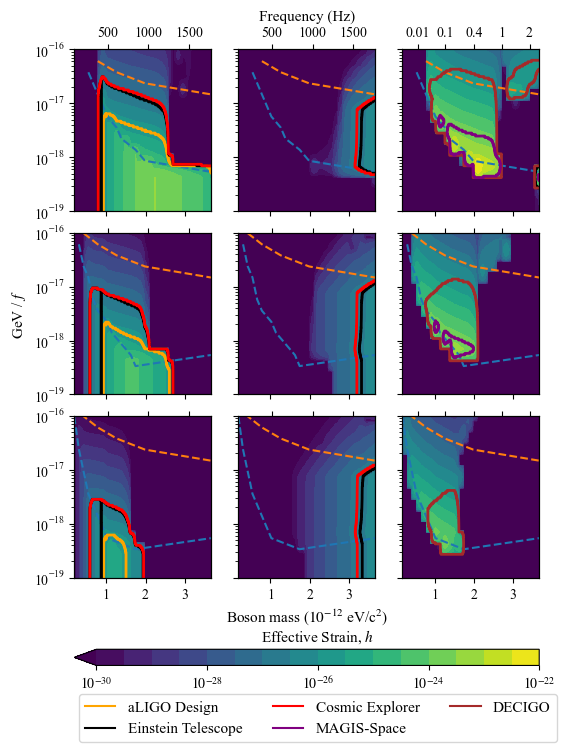

In [7]:
#######################
# Generate the figure #
#######################
# Define the line width
lw = 2.0

# Initialise the figure
fig = plt.figure(figsize=(6, 8.))
gs = GridSpec(5, 3, height_ratios=[1, 1, 1, 0.18, 0.1])

# Create 9 contour plots
ax = []

for i, age in enumerate(ages):
    # Cut h0 values for nice plots
    # Define ranges of log scales:
    min_bound = -30
    max_bound = -22
    num_scale = 2
    h_211_211_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
    h_322_322_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
    h_322_to_211_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)

    # Clean data of values outside of this range
    h_211_211_an_c_V = h_211_211_an_subset_V_dict[age]
    h_322_322_an_c_V = h_322_322_an_subset_V_dict[age]
    h_322_to_211_c_V = h_322_to_211_subset_V_dict[age]
    for j in range(len(h_211_211_an_c_V)):
        for k in range(len(h_211_211_an_c_V[j])):
            if h_211_211_an_c_V[j][k]<10**min_bound:
                h_211_211_an_c_V[j][k]=10**min_bound
            if h_322_322_an_c_V[j][k]<10**min_bound:
                h_322_322_an_c_V[j][k]=10**min_bound
            if h_322_to_211_c_V[j][k]<10**min_bound:
                h_322_to_211_c_V[j][k]=10**min_bound

    # 211 Annihilation
    ax.append(fig.add_subplot(gs[i, 0]))
    plot = ax[-1].contourf(bm_subset_V*1e12,1/f_subset_V,h_211_211_an_c_V*h_factor_211,h_211_211_an_crange,norm=LogNorm(),extend="min")
    ax[-1].plot(bm_grav_mod_dic[age]*1e12,1/grav_mod_dic[age],linestyle="--",color="C0")
    ax[-1].plot(bm_mod_strong_dic[age]*1e12,1/mod_strong_dic[age],linestyle="--",color="C1")
    #ax[-1].plot(bm_strong_very_strong_dic[age]*1e12,1/strong_very_strong_dic[age],linestyle="--",color="C3")
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict_dict[age]["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
    ax[-1].set_ylim(1e-19,1e-16)
    ax[-1].set_yscale('log')
    if i !=2:
        ax[-1].set_xticklabels([])
    ax[-1].plot(bm_vals*1e12,func.compute_f_axion(bm_vals)**-1,linestyle=':',color='white')
        
    # 322 Annihilation
    ax.append(fig.add_subplot(gs[i, 1]))
    plot = ax[-1].contourf(bm_subset_V*1e12,1/f_subset_V,h_322_322_an_c_V*h_factor_322,h_211_211_an_crange,norm=LogNorm(),extend="min")
    ax[-1].plot(bm_grav_mod_dic[age]*1e12,1/grav_mod_dic[age],linestyle="--",color="C0")
    ax[-1].plot(bm_mod_strong_dic[age]*1e12,1/mod_strong_dic[age],linestyle="--",color="C1")
    #ax[-1].plot(bm_strong_very_strong_dic[age]*1e12,1/strong_very_strong_dic[age],linestyle="--",color="C3")
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict_dict[age]["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict_dict[age]["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict_dict[age]["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict_dict[age]["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict_dict[age]["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
    ax[-1].set_ylim(1e-19,1e-16)
    ax[-1].set_yscale('log')
    if i!= 2:
        ax[-1].set_yticklabels([])
        ax[-1].set_xticklabels([])
    else:
        ax[-1].set_yticklabels([])
    ax[-1].plot(bm_vals*1e12,func.compute_f_axion(bm_vals)**-1,linestyle=':',color='white')
    
    # 322 to 211 Transition
    ax.append(fig.add_subplot(gs[i, 2]))
    plot = ax[-1].contourf(bm_subset_V*1e12,1/f_subset_V,h_322_to_211_c_V*h_factor_tr,h_211_211_an_crange,norm=LogNorm(),extend="min")
    ax[-1].plot(bm_grav_mod_dic[age]*1e12,1/grav_mod_dic[age],linestyle="--",color="C0")
    ax[-1].plot(bm_mod_strong_dic[age]*1e12,1/mod_strong_dic[age],linestyle="--",color="C1")
    #ax[-1].plot(bm_strong_very_strong_dic[age]*1e12,1/strong_very_strong_dic[age],linestyle="--",color="C3")
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict_dict[age]["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict_dict[age]["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict_dict[age]["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict_dict[age]["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
    ax[-1].contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict_dict[age]["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
    ax[-1].set_ylim(1e-19,1e-16)
    ax[-1].set_yscale('log')
    if i!= 2:
        ax[-1].set_yticklabels([])
        ax[-1].set_xticklabels([])
    else:
        ax[-1].set_yticklabels([])
    ax[-1].plot(bm_vals*1e12,func.compute_f_axion(bm_vals)**-1,linestyle=':',color='white')
            
# Pretty up the figure; labels, colorbar, etc.
# Add y labels
#ax[0].set_ylabel("GeV / $f$",fontsize=11)
ax[3].set_ylabel("GeV / $f$",fontsize=11)
#ax[6].set_ylabel("GeV / $f$",fontsize=11)

# Add x labels
#ax[6].set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
ax[7].set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax[8].set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)

# Set frequency ticks
# Compute the frequencies
nu_211_211_an_vals = np.zeros_like(bm_subset_V[0])*np.nan
nu_322_322_an_vals = np.zeros_like(bm_subset_V[0])*np.nan
nu_322_to_211_vals = np.zeros_like(bm_subset_V[0])*np.nan
for i, bm in enumerate(bm_subset_V[0]):
    # Compute energies
    E_211_211_an = 2*func.compute_energy(bm, bhm, 2)
    E_322_322_an = 2*func.compute_energy(bm, bhm, 3)
    E_322_to_211 = func.compute_energy(bm, bhm, 3) - func.compute_energy(bm, bhm, 2)
    # Compute frequencies
    nu_211_211_an = E_211_211_an/h
    nu_322_322_an = E_322_322_an/h
    nu_322_to_211 = E_322_to_211/h
    # Store frequencies
    nu_211_211_an_vals[i] = nu_211_211_an
    nu_322_322_an_vals[i] = nu_322_322_an
    nu_322_to_211_vals[i] = nu_322_to_211
# Define frequency ticks
tick_nu_211_an = np.array([500,1000,1500],dtype=float)
tick_nu_211_an_loc = np.zeros_like(tick_nu_211_an)
for i in range(len(tick_nu_211_an)):
    tick_nu_211_an_loc[i] = interpolate(nu_211_211_an_vals,bm_subset_V[0],tick_nu_211_an[i])
tick_nu_322_an = np.array([500,1000,1500],dtype=float)
tick_nu_322_an_loc = np.zeros_like(tick_nu_322_an)
for i in range(len(tick_nu_322_an)):
    tick_nu_322_an_loc[i] = interpolate(nu_322_322_an_vals,bm_subset_V[0],tick_nu_322_an[i])
tick_nu_tr = np.array([1e-2,1e-1,4e-1,1e0,2e0])
tick_nu_tr_loc = np.zeros_like(tick_nu_tr)
for i in range(len(tick_nu_tr)):
    tick_nu_tr_loc[i] = interpolate(nu_322_to_211_vals,bm_subset_V[0],tick_nu_tr[i])
    
for i, sax in enumerate(ax):
    tax = sax.twiny()
    tax.set_xlim(sax.get_xlim())
    if i % 3 == 0:
        tax.set_xticks(tick_nu_211_an_loc*1e12)
        if i == 0:
            tax.set_xticklabels(['500','1000','1500'])
            #tax.set_xlabel(r"Frequency (Hz)", fontsize=11)
        else:
            tax.set_xticklabels([])
    if i % 3 == 1: 
        tax.set_xticks(tick_nu_322_an_loc*1e12)
        if i == 1:
            tax.set_xticklabels(['500','1000','1500'])
            tax.set_xlabel(r"Frequency (Hz)", fontsize=11)
        else:
            tax.set_xticklabels([])
    if i % 3 == 2:
        tax.set_xticks(tick_nu_tr_loc*1e12)
        if i == 2:
            tax.set_xticklabels(['0.01','0.1','0.4','1','2'])
            #tax.set_xlabel(r"Frequency (Hz)", fontsize=11)
        else:
            tax.set_xticklabels([])

# Add colorbar
my_ticks = [1e-30,1e-28,1e-26,1e-24,1e-22]
my_tick_labels = [r"$10^{-30}$","$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$"]
cbar_ax = fig.add_subplot(gs[4, :])
cbar = fig.colorbar(plot,cax=cbar_ax,pad=0.6,ticks=my_ticks,orientation='horizontal')
cbar.ax.set_xticklabels(my_tick_labels)
cbar.ax.set_title(r"Effective Strain, $h$", fontsize=11)

# Add legend
line1 = Line2D([0],[0],label="aLIGO Design", color = conf.line_dic["aligo_design"][0])
line2 = Line2D([0],[0],label="Einstein Telescope", color = conf.line_dic["et_d"][0])
line3 = Line2D([0],[0],label="Cosmic Explorer", color = conf.line_dic["ce2"][0])
line4 = Line2D([0],[0],label="MAGIS-Space", color = conf.line_dic["magiss-r"][0])
line5 = Line2D([0],[0],label="DECIGO", color = conf.line_dic["decigo"][0])
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line1,line2,line3,line4,line5])
cbar_ax.legend(handles=handles, loc = "lower center",bbox_to_anchor = [0.5,-5.2],fontsize=11,ncol=3)

# Show figure in all its glory
plt.savefig("MOAAgeSearch.pdf",bbox_inches="tight")
plt.show()